# Edge finder

In [ ]:
sigma_d = '1 km'
sigma_t = '1 year'
sigma_

In [133]:
import numpy as np
import netCDF4

from scipy import (special, signal, ndimage)
from scipy.ndimage import gaussian_filter

from ipywidgets import (interact)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

plt.rcParams['figure.figsize'] = (25, 10)

import os

path = "/mnt/Knolselderij/bulk/Abrupt/"
fn1 = "tas_Amon_MPI-ESM-LR_rcp85_r1i1p1_200601-210012.nc"
fn2 = "tas_Amon_MPI-ESM-LR_rcp85_r1i1p1_210101-230012.nc"


def plot_orthographic_np(lats, lons, tas, **pargs):
    tas = np.concatenate([tas[:,:], tas[:, 0:1]], axis=1)
    lons = np.concatenate([lons, lons[0:1]])
    lats = np.concatenate([lats, [90.0]])
    tas = np.concatenate([tas[:,:], tas[0:1,:]], axis=0)

    proj=ccrs.Orthographic(central_latitude=90)
    ax = plt.axes(projection=proj)
    plt.pcolormesh(
        lons, lats, tas, **pargs,
        transform=ccrs.RotatedPole(pole_longitude=180.0, pole_latitude=90))
    ax.coastlines()
    plt.colorbar()
    plt.show()

    
def plot_mollweide(lats, lons, tas, **pargs):
    tas = np.concatenate([tas[:,:], tas[:, 0:1]], axis=1)
    lons = np.concatenate([lons, lons[0:1]])

    proj=ccrs.Mollweide()
    ax = plt.axes(projection=proj)
    plt.pcolormesh(
        lons, lats, tas, **pargs,
        transform=ccrs.RotatedPole(pole_longitude=180, pole_latitude=90))
    ax.coastlines()
    plt.colorbar()
    plt.show()

    
def plot_plate_carree(lats, lons, tas):
    tas = np.concatenate([tas[:,:], tas[:, 0:1]], axis=1)
    lons = np.concatenate([lons, lons[0:1]])

    proj=ccrs.PlateCarree()
    ax = plt.axes(projection=proj)
    plt.pcolormesh(
        lons, lats, tas,
        transform=ccrs.RotatedPole(pole_longitude=180, pole_latitude=90))
    ax.coastlines()
    plt.colorbar()
    plt.show()

In [29]:
def get_data(filename):
    return netCDF4.Dataset(filename, 'r', format='NETCDF4')

def plot_image(data):
    ratio = data.shape[0] / data.shape[1]
    p = figure(x_range=(0, data.shape[1]), y_range=(0, data.shape[0]), plot_width=int(378/ratio), plot_height=378)
    p.image(image=[data], x=0, y=0, dw=data.shape[1], dh=data.shape[0], palette=bokeh.palettes.viridis(255))
    show(p)

data = np.concatenate([
    get_data(os.path.join(path, fn1)).variables['tas'],
    get_data(os.path.join(path, fn2)).variables['tas']],
    axis=0)
dataset = get_data(os.path.join(path, fn1))
lats = dataset.variables['lat']
lons = dataset.variables['lon']

## Compute the variance of the data
This to assess the magnitude of something that should be considered _extreme_.

In [30]:
control_files = [
    "tas_Amon_MPI-ESM-LR_piControl_r1i1p1_185001-203512.nc",
    "tas_Amon_MPI-ESM-LR_piControl_r1i1p1_203601-213012.nc",
    "tas_Amon_MPI-ESM-LR_piControl_r1i1p1_213101-223012.nc",
    "tas_Amon_MPI-ESM-LR_piControl_r1i1p1_223101-233012.nc",
    "tas_Amon_MPI-ESM-LR_piControl_r1i1p1_233101-249912.nc",
    "tas_Amon_MPI-ESM-LR_piControl_r1i1p1_250001-269912.nc",
    "tas_Amon_MPI-ESM-LR_piControl_r1i1p1_270001-284912.nc"]
# FIXME: put this in wildcard notation

In [31]:
def compute_std(files, variable):
    sum_lin = 0
    sum_sqr = 0
    n = 0

    for f in files:
        d = get_data(os.path.join(path, f)).variables[variable][:]
        sum_lin += d.sum(axis=0)
        sum_sqr += (d**2).sum(axis=0)
        n += d.shape[0]
        del d
    
    return np.sqrt(sum_sqr/n - (sum_lin/n)**2)

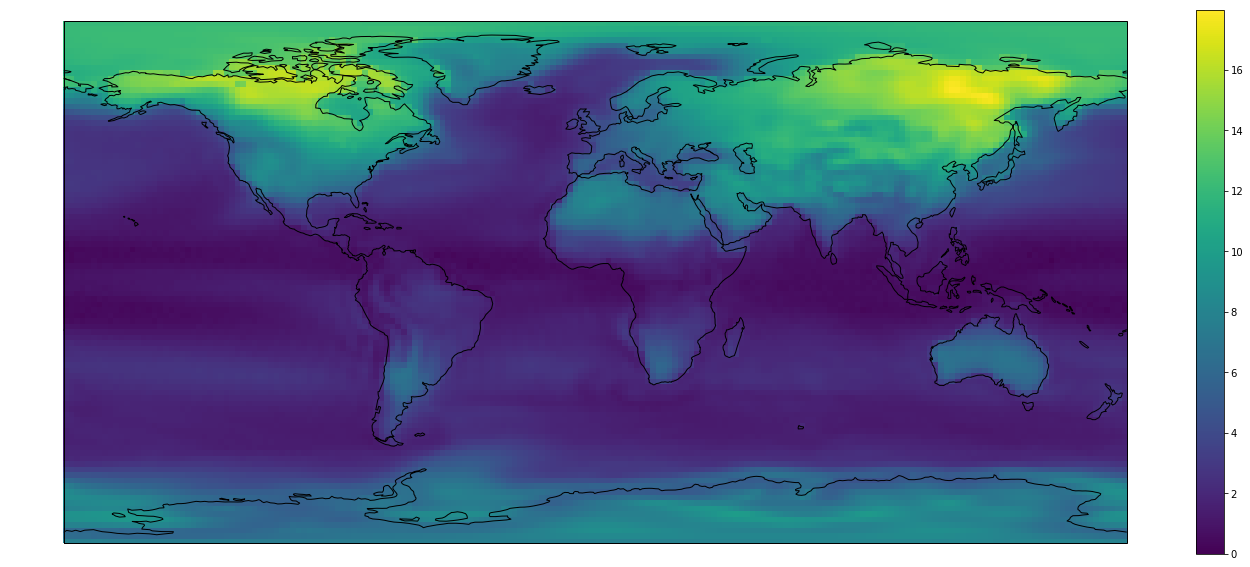

In [32]:
std = compute_std(control_files, 'tas')
plot_plate_carree(lats, lons, std)

## Canny edges

In [11]:
from copy import copy

def is_linear(a, eps=1e-3):
    x = np.diff(a[1:-1]).std() / np.diff(a[1:-1]).mean()
    return x < eps


R_earth = 6.371e3             # km
day = 0.0027378507871321013   # years


class Box:
    def __init__(self, nc):
        self.lat = nc.variables['lat']
        self.lon = nc.variables['lon']
        self.time = nc.variables['time']
    
    def __getitem__(self, s):
        new_box = copy(self)
        
        if not isinstance(s, tuple):
            s = (s,)
        
        for q, t in zip(s, ['time', 'lat', 'lon']):
            setattr(new_box, t, getattr(self, t).__getitem__(s))
        
        return new_box
            
    @property
    def rectangular(self):
        return is_linear(self.lat) and is_linear(self.lon)
    
    @property
    def resolution(self):
        res_lat = np.diff(self.lat[1:-1]).mean() * (np.pi / 180) * R_earth
        res_lon = np.diff(self.lon[1:-1]).mean() * (np.pi / 180) * R_earth
        res_time = np.diff(self.time[1:-1]).mean() * day
        return res_time, res_lat, res_lon


box = Box(get_data(os.path.join(path, fn1)))

In [12]:
box[2::12].resolution

(1.0, 207.37861992560408, 208.49048745854762)

In [13]:
def smooth(box, data, sigma_t, sigma_lat, sigma_lon):
    res_t, res_lat, res_lon = box.resolution
    outp = np.zeros_like(data)
    # FIXME: set the 'mode' parameter for cilindric coordinates.
    gaussian_filter(data, [sigma_t / res_t, sigma_lat / res_lat, 0.0], output=outp)
    
    data[:] = outp
    h = data.shape[1] / 2
    for i in range(data.shape[1]):
        gaussian_filter(
            data[:,i,:],
            min(data.shape[2], (sigma_lon /res_lon) / np.cos((h - i) / (2*h) * np.pi)),
            output=outp[:,i,:])

    return outp

smooth_data = smooth(box[2::12], data[2::12], 10.0, 200, 200)

In [18]:
def plot_cube(plot_data):
    n, m = plot_data.min(), plot_data.max()
    proj=ccrs.PlateCarree()
    plot_data = np.concatenate([plot_data[:,:,:], plot_data[:, :, 0:1]], axis=2)
    plons = np.concatenate([lons, lons[0:1]])
    
    def do_plot(y):
        t = (y - 2006) # * 12 + m
        ax = plt.axes(projection=proj)
        plt.pcolormesh(
            plons, lats, plot_data[t], vmin=n, vmax=m,
            transform=ccrs.RotatedPole(pole_longitude=180, pole_latitude=90))
        ax.coastlines()
        plt.colorbar()
        plt.show()
    
    interact(do_plot, y=(2006, 2006+plot_data.shape[0] - 1))

plot_cube(smooth_data)

interactive(children=(IntSlider(value=2153, description='y', max=2300, min=2006), Output()), _dom_classes=('widget-interact',))

In [19]:
def full_sobel(box, smooth_data, weights):
    dim = len(smooth_data.shape)
    y = [w * r for r, w in zip(box.resolution, weights)]
    
    sb = np.array([
        ndimage.sobel(smooth_data, mode=['reflect', 'reflect', 'wrap'], axis=i) * y[i]
        for i in range(dim)])
    # FIXME: include np.cos((h - i) / (2*h) * np.pi)
    sb = np.r_[sb, np.ones_like(sb[0:1])]
    norm = np.sqrt((sb[:dim]**2).sum(axis=0))
    sb /= norm
    
    return sb

In [259]:
sb = full_sobel(box[2::12], smooth_data, weights=[100., 0.01, 0.01])

In [260]:
from hyper_canny import cp_edge_thinning, cp_double_threshold

In [261]:
dat = sb.transpose([3,2,1,0]).copy()
mask = cp_edge_thinning(dat)

In [271]:
edges = cp_double_threshold(data=dat, mask=mask, a=1./1400, b=1./1000)
m = edges.transpose([2, 1, 0])

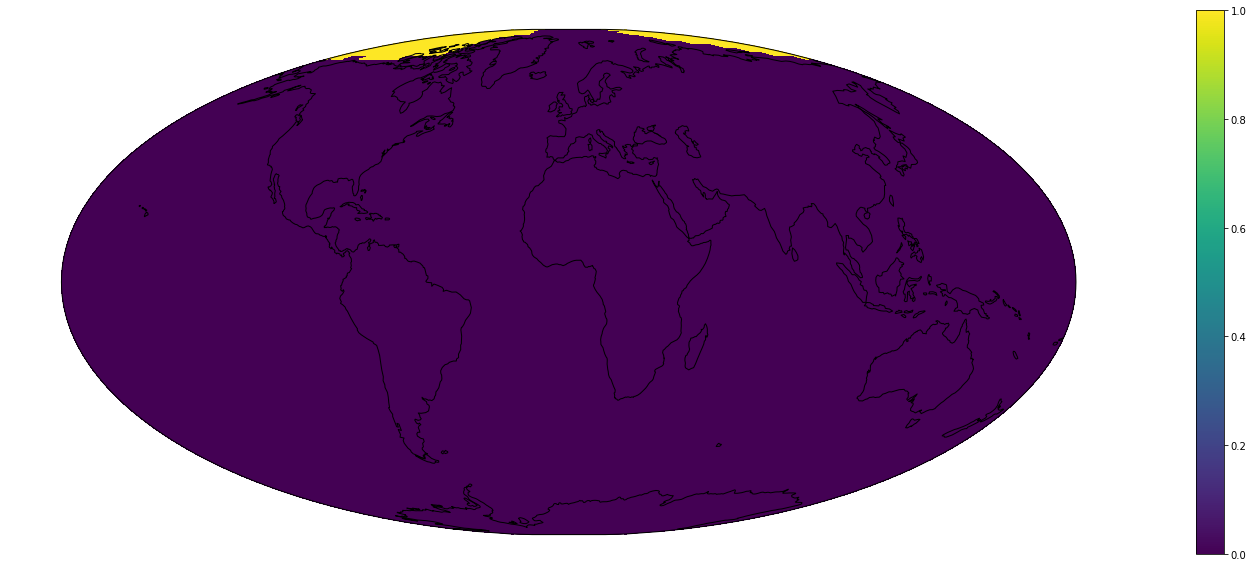

In [276]:
plot_mollweide(lats, lons, np.sqrt(m.sum(axis=0)))

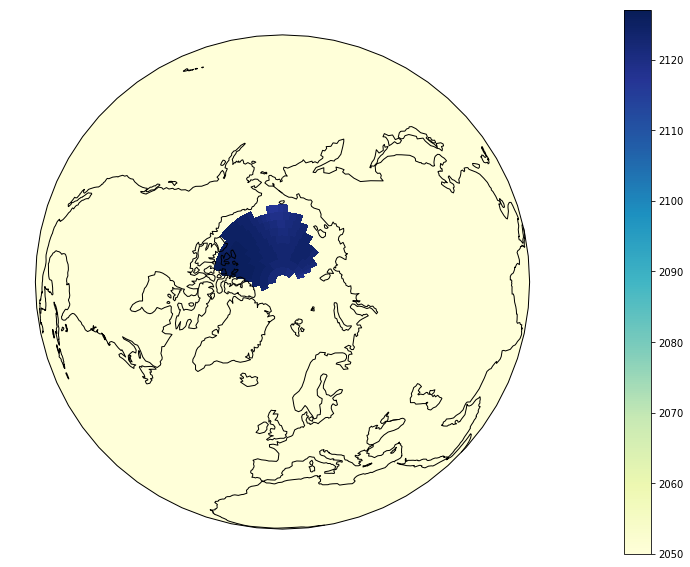

In [273]:
plot_orthographic_np(lats, lons, 2006+(np.indices(m.shape)[0]*m).max(axis=0),  cmap='YlGnBu', vmin=2050)

In [274]:
f = open('rcp85-tas-cp.txt', 'w')
np.savetxt('rcp85-tas-cp.txt', np.roll((np.indices(m.shape)[0]*m).max(axis=0), 192//2, axis=1))

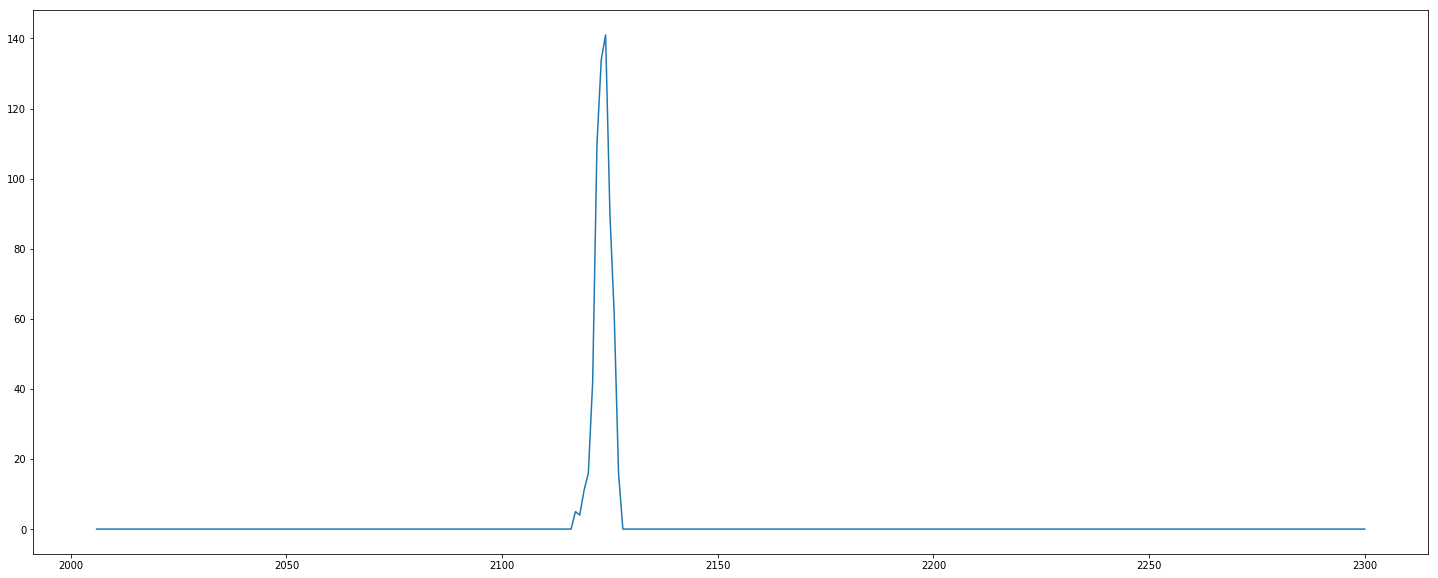

In [275]:
time = np.arange(m.shape[0]) + 2006
plt.plot(time, m.sum(axis=1).sum(axis=1))
plt.show()

In [267]:
signal = np.abs(1./sb[3,:,:,:])

In [268]:
signal_flat = signal.reshape([295, -1])

In [269]:
n_bins = 100
bins = np.linspace(signal.min(), signal.max(), n_bins+1)
hist = np.zeros(shape=(295, n_bins))
for t in range(295):
    h, _ = np.histogram(signal_flat[t], bins=bins)
    hist[t, :] = h

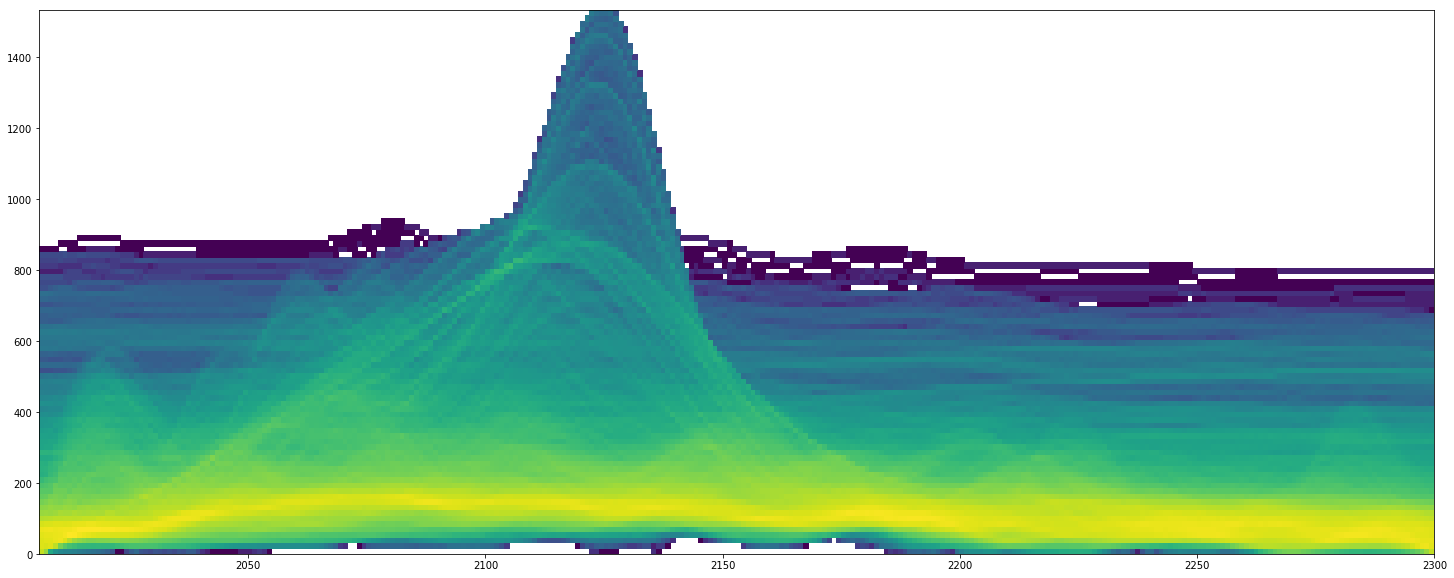

In [270]:
plt.pcolormesh(np.arange(295)+2006, bins[:-1], hist.T,
              norm=colors.LogNorm(vmin=1, vmax=hist.max()))
plt.show()

In [246]:
np.median(signal)

0.90725708